# Explainable Breast Cancer Classification with SAFE & Shapley-Lorenz
* Student: Martina Cavallucci
* Rapporteur: Emanuela Raffineti

#### Import and install library

In [ ]:
!pip install catboost xgboost safeaipackage
# Standard Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Data Preprocessing and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer

# SAFE AI and Shapley-Lorenz
from safeaipackage import core, check_explainability, check_fairness, check_robustness

In [92]:
# Loading Breast Cancer Dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Data Exploration (EDA - Exploratory Data Analysis)

This section will analyze the dataset and provide insights before training models.

In [ ]:
def explore_dataset(df):
    """
    Perform exploratory data analysis (EDA) on the dataset.
    This function provides:
    - Basic dataset information (shape, data types, missing values)
    - Summary statistics (mean, variance, skewness, kurtosis)
    - A correlation heatmap
    """

    # 1. Display dataset shape (number of rows and columns)
    print("\n Dataset Dimensions:", df.shape)

    # 2. Show the first five rows to get an overview
    print("\n First Five Rows of the Dataset:\n", df.head())

    # 3. Check data types and missing values
    print("\n Dataset Information:")
    print(df.info())

    # 4. Count missing values in each column
    print("\n Missing Values per Column:\n", df.isnull().sum())

    # 5. Generate summary statistics (mean, std, min, max, etc.)
    print("\n Summary Statistics:\n", df.describe())

    # 6. Compute skewness and kurtosis for numerical features
    skewness = df.apply(lambda x: skew(x.dropna()) if x.dtype != 'O' else np.nan)
    kurtosis_vals = df.apply(lambda x: kurtosis(x.dropna()) if x.dtype != 'O' else np.nan)
    skew_df = pd.DataFrame({"Feature": df.columns, "Skewness": skewness, "Kurtosis": kurtosis_vals})

    print("\n Skewness and Kurtosis of Numerical Features:\n", skew_df)

    # 7. Plot the correlation heatmap to identify feature relationships
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
    plt.title("📊 Correlation Heatmap")
    plt.show()

# Apply the function to explore your dataset
explore_dataset(df)

In [ ]:
def plot_feature_distributions(df, num_features=6):
    """
    Plots the distribution of selected numerical features.
    - Histograms show the frequency of values.
    - KDE curves show the probability density.
    - num_features: Number of features to plot to avoid overcrowding.
    """
    features_to_plot = df.columns[:num_features]  # Select first N features

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Create subplots in a 2x3 grid
    axes = axes.flatten()  # Flatten to loop easily

    for i, feature in enumerate(features_to_plot):
        sns.histplot(df[feature], bins=30, kde=True, ax=axes[i], color="royalblue")
        axes[i].set_title(f"Distribution of {feature}")

    plt.tight_layout()
    plt.show()

# Apply the function
plot_feature_distributions(df.drop(columns=["target"]), num_features=6)

In [ ]:
def plot_feature_distributions_by_class(df, target_col, num_features=6):
    """
    Plots the distribution of numerical features separated by class.
    - num_features: Number of features to plot to avoid overcrowding.
    """
    features_to_plot = df.drop(columns=[target_col]).columns[:num_features]  # Select first N features

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, feature in enumerate(features_to_plot):
        sns.histplot(data=df, x=feature, hue=target_col, bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {feature} by Class")

    plt.tight_layout()
    plt.show()

# Apply the function
plot_feature_distributions_by_class(df, target_col="target", num_features=6)

In [ ]:
def plot_boxplots(df, num_features=6):
    """
    Plots boxplots for numerical features to detect outliers.
    """
    features_to_plot = df.columns[:num_features]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, feature in enumerate(features_to_plot):
        sns.boxplot(y=df[feature], ax=axes[i], color="tomato")
        axes[i].set_title(f"Boxplot of {feature}")

    plt.tight_layout()
    plt.show()

# Apply the function
plot_boxplots(df.drop(columns=["target"]), num_features=6)

# Data Preprocessing

This section prepares the data before feeding it into ML models.


In [93]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_data(df, target_col, num_features=10, scale_data=True):
    """
    Preprocesses the dataset:
    - Selects the first `num_features` variables.
    - Scales the features (optional).
    - Splits into train and test sets.

    Returns:
    - X_train, X_test, y_train, y_test, feature_names
    """

    # 1. Select only the first `num_features` variables
    selected_features = df.drop(columns=[target_col]).columns[:num_features]
    X = df[selected_features]
    y = df[target_col]

    print(f"\n🔹 Using only the first {num_features} features:\n", selected_features.tolist())

    # 2. Split dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 3. Store feature names (to reassign after scaling)
    feature_names = X_train.columns.tolist()

    # 4. Scale the data if needed
    scaler = None
    if scale_data:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Convert back to DataFrame with column names
        X_train = pd.DataFrame(X_train, columns=feature_names)
        X_test = pd.DataFrame(X_test, columns=feature_names)

    print("\n Data Preprocessing Completed!")

    return X_train, X_test, y_train, y_test, feature_names

# Apply the preprocessing function
X_train, X_test, y_train, y_test, feature_names = preprocess_data(df, target_col="target", num_features=10, scale_data=True)



🔹 Using only the first 10 features:
 ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension']

 Data Preprocessing Completed!


# Model Training

This section trains multiple machine learning models and compares their performance.


In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    """
    Trains and evaluates multiple machine learning models.
    - Computes Accuracy and AUROC for each model.
    - Returns a DataFrame with the results.
    """

    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(eval_metric="logloss")
    }

    # Store results
    results = []

    for name, model in models.items():
        print(f"\n Training {name}...")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for AUROC

        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)

        print(f"{name} - Accuracy: {accuracy:.4f}, AUROC: {auc:.4f}")

        # Save results
        results.append({"Model": name, "Accuracy": accuracy, "AUROC": auc})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df, models

# Train and evaluate models
model_results, trained_models = train_and_evaluate_models(X_train, y_train, X_test, y_test)

# Display the results
print("\n Model Performance Comparison:")
print(model_results)


 Training Logistic Regression...
Logistic Regression - Accuracy: 0.8947, AUROC: 0.9805

 Training Random Forest...
Random Forest - Accuracy: 0.9474, AUROC: 0.9901

 Training XGBoost...
XGBoost - Accuracy: 0.9386, AUROC: 0.9861

 Model Performance Comparison:
                 Model  Accuracy     AUROC
0  Logistic Regression  0.894737  0.980489
1        Random Forest  0.947368  0.990079
2              XGBoost  0.938596  0.986111


## Compute Class-wise Performance Metrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def detailed_model_analysis(models, X_test, y_test):
    """
    Analyzes the classification performance for each model.
    - Prints confusion matrices.
    - Displays Precision, Recall, and F1-score for each class.
    """
    for name, model in models.items():
        print(f"\n Analyzing {name}...")

        # Predictions
        y_pred = model.predict(X_test)

        # Classification Report
        print("\n📊 Classification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot Confusion Matrix
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

# Perform detailed analysis
detailed_model_analysis(trained_models, X_test, y_test)

# Feature Importance Analysis

This section analyzes feature importance using Shapley-Lorenz and SAFE AI.


## Compute SAFE AI Feature Importance

In [101]:
from safeaipackage import check_explainability

def compute_safe_explainability(models, X_train, X_test,feature_names):
    """
    Computes SAFE AI RGE (Rank-based Global Explainability) feature importance for each model.
    Returns a dictionary with feature importances.
    """
    safe_importance = {}

    for name, model in models.items():
        print(f"\n🔹 Computing SAFE AI Explainability for {name}...")
        rge_results  = check_explainability.compute_rge_values(
            X_train, X_test, model.predict_proba(X_test)[:, 1], model, feature_names
        )

        #safe_importance[name] = np.array(rge_values).flatten()
        # Store as dictionary instead of NumPy array
        #safe_importance[name] = {feature_names[i]: rge_values[i] for i in range(len(feature_names))}

        # Extract RGE values properly from the DataFrame
        if isinstance(rge_results, pd.DataFrame) and "RGE" in rge_results.columns:
            rge_values = rge_results["RGE"].to_dict()  # Convert DataFrame to a dictionary
            safe_importance[name] = rge_values
        else:
            print(f"⚠️ Warning: Unexpected format for RGE values in {name}. Skipping...")
            safe_importance[name] = {}

    return safe_importance

# Compute SAFE AI Feature Importance
safe_feature_importance = compute_safe_explainability(trained_models, X_train, X_test,feature_names)


🔹 Computing SAFE AI Explainability for Logistic Regression...

🔹 Computing SAFE AI Explainability for Random Forest...

🔹 Computing SAFE AI Explainability for XGBoost...


In [95]:
def compute_safe_ai_metrics(models, X_train, X_test, feature_names):
    """
    Computes SAFE AI feature importance metrics (Explainability - RGE & Robustness - RGR) for each model.
    Returns a dictionary with both RGE and RGR per model.

    Parameters:
    - models: Dictionary of trained models.
    - X_train, X_test: Training and testing feature sets.
    - feature_names: List of feature names.

    Returns:
    - A dictionary with RGE (explainability) and RGR (robustness) values for each model.
    """
    safe_metrics = {}

    for name, model in models.items():
        print(f"\n🔹 Computing SAFE AI Metrics for {name}...")

        # Compute Explainability (RGE)
        rge_results = check_explainability.compute_rge_values(
            X_train, X_test, model.predict_proba(X_test)[:, 1], model, feature_names
        )

        # Compute Robustness (RGR)
        rgr_results = check_robustness.compute_rgr_values(
            X_test, model.predict_proba(X_test)[:, 1], model, feature_names
        )

        # ✅ Store as dictionary
        if isinstance(rge_results, pd.DataFrame) and "RGE" in rge_results.columns:
            rge_values = rge_results["RGE"].to_dict()
        else:
            print(f"⚠️ Warning: Unexpected format for RGE values in {name}. Skipping...")
            rge_values = {}

        if isinstance(rgr_results, pd.DataFrame) and "RGR" in rgr_results.columns:
            rgr_values = rgr_results["RGR"].to_dict()
        else:
            print(f"⚠️ Warning: Unexpected format for RGR values in {name}. Skipping...")
            rgr_values = {}

        safe_metrics[name] = {"RGE": rge_values, "RGR": rgr_values}

    return safe_metrics

# ✅ Compute SAFE AI Metrics (Explainability + Robustness)
safe_ai_metrics = compute_safe_ai_metrics(trained_models, X_train, X_test,feature_names)



🔹 Computing SAFE AI Metrics for Logistic Regression...

🔹 Computing SAFE AI Metrics for Random Forest...

🔹 Computing SAFE AI Metrics for XGBoost...


In [96]:
safe_ai_metrics

{'Logistic Regression': {'RGE': {'mean smoothness': 0.01160460703225763,
   'mean texture': 0.010863906491477615,
   'mean symmetry': 0.0021858945548552944,
   'mean radius': 0.002103701484987841,
   'mean area': 0.002014402788672154,
   'mean concave points': 0.0017664295511472528,
   'mean perimeter': 0.001412701141016326,
   'mean fractal dimension': 0.0010971619048315562,
   'mean concavity': 0.0005741311213594003,
   'mean compactness': 0.0001513043693803784},
  'RGR': {'mean compactness': 0.9999141849754977,
   'mean concavity': 0.9999138187582454,
   'mean perimeter': 0.9998125840588259,
   'mean fractal dimension': 0.9981750949136268,
   'mean texture': 0.9975072978306883,
   'mean radius': 0.9968783032904293,
   'mean symmetry': 0.9967541363418276,
   'mean concave points': 0.9961740849155474,
   'mean area': 0.9952474296198661,
   'mean smoothness': 0.9798167809844902}},
 'Random Forest': {'RGE': {'mean concave points': 0.028372888315937206,
   'mean area': 0.0145592180331676

## Compute Shapley-Lorenz Feature Importance

In [ ]:
import numpy as np
import pandas as pd
import shap

def compute_shapley_lorenz_for_models(models, X_train, X_test, y_train, y_test):
    """
    Computes Shapley-Lorenz feature importance for multiple models.
    Returns a dictionary with feature importance per model.
    """
    feature_names = list(X_train.columns)
    K = len(feature_names)
    shapley_importance = {}

    def lorenz_zonoid(y):
        n = len(y)
        y_bar = np.mean(y)
        y_sorted = np.sort(y)
        indices = np.arange(1, n+1)
        term = np.sum(indices * y_sorted) / n - (n + 1) / 2
        return 2 / (n * y_bar) * term

    def get_predictions(feature_set, X_train, y_train, X_test, model):
        if len(feature_set) == 0:
            return np.full(len(X_test), np.mean(y_train))  # Baseline prediction

        model.fit(X_train[list(feature_set)], y_train)
        return model.predict_proba(X_test[list(feature_set)])[:, 1]

    def f(mask_matrix, X_train, y_train, X_test, model):
        results = []
        for mask in mask_matrix:
            subset = {feature_names[i] for i in range(K) if mask[i] == 1}
            preds = get_predictions(subset, X_train, y_train, X_test, model)
            results.append(lorenz_zonoid(preds))
        return np.array(results)

    for model_name, model in models.items():
        print(f"\n🔹 Computing Shapley-Lorenz for {model_name}...")

        background = np.zeros((1, K))
        x_all_features = np.ones((1, K))

        explainer = shap.KernelExplainer(lambda mask: f(mask, X_train, y_train, X_test, model), background)
        shap_values = explainer.shap_values(x_all_features, nsamples=1000)

        # Store as dictionary instead of NumPy array
        shapley_importance[model_name] = {feature_names[i]: shap_values[0][i] for i in range(K)}

    return shapley_importance

# Compute Shapley-Lorenz Feature Importance
shapley_feature_importance = compute_shapley_lorenz_for_models(trained_models, X_train, X_test, y_train, y_test)

## Combine Feature Importance into a Single Table

In [103]:
def compare_feature_importance(safe_imp, shapley_imp, feature_names, models):
    """
    Creates a comparison table of feature importance across SAFE AI and Shapley-Lorenz for each model.

    Parameters:
    - safe_imp: Dictionary containing SAFE AI importance values per model.
    - shapley_imp: Dictionary containing Shapley-Lorenz importance values per model.
    - feature_names: List of feature names.
    - models: Dictionary of trained models.

    Returns:
    - A Pandas DataFrame sorted by SAFE AI importance for one of the models (Logistic Regression as reference).
    """
    results = []

    for feature in feature_names:
        row = {"Feature": feature}

        for model_name in models.keys():
            row[f"SAFE AI ({model_name})"] = safe_imp.get(model_name, {}).get(feature, np.nan)
            row[f"Shapley-Lorenz ({model_name})"] = shapley_imp.get(model_name, {}).get(feature, np.nan)

        results.append(row)

    importance_df = pd.DataFrame(results)

    # Sort by SAFE AI (Logistic Regression) Importance, using NaN-safe sorting
    reference_model = "Logistic Regression" if "Logistic Regression" in models else list(models.keys())[0]
    importance_df = importance_df.sort_values(by=f"SAFE AI ({reference_model})", ascending=False, na_position='last')

    return importance_df

# Create Comparison Table
feature_comparison_df = compare_feature_importance(
    safe_feature_importance, shapley_feature_importance, X_train.columns, trained_models
)

In [99]:
def compare_feature_importance(safe_metrics, shapley_imp, feature_names, models):
    """
    Creates a comparison table including SAFE AI Explainability (RGE), Robustness (RGR), and Shapley-Lorenz.

    Parameters:
    - safe_metrics: Dictionary containing SAFE AI RGE and RGR values per model.
    - shapley_imp: Dictionary containing Shapley-Lorenz importance values per model.
    - feature_names: List of feature names.
    - models: Dictionary of trained models.

    Returns:
    - A Pandas DataFrame sorted by SAFE AI RGE importance for one of the models (Logistic Regression as reference).
    """
    results = []

    for feature in feature_names:
        row = {"Feature": feature}

        for model_name in models.keys():
            row[f"SAFE AI - Explainability (RGE) ({model_name})"] = safe_metrics[model_name]["RGE"].get(feature, np.nan)
            row[f"SAFE AI - Robustness (RGR) ({model_name})"] = safe_metrics[model_name]["RGR"].get(feature, np.nan)
            row[f"Shapley-Lorenz ({model_name})"] = shapley_imp[model_name].get(feature, np.nan)

        results.append(row)

    importance_df = pd.DataFrame(results)

    # Sort by SAFE AI RGE (Logistic Regression) Importance, using NaN-safe sorting
    reference_model = "Logistic Regression" if "Logistic Regression" in models else list(models.keys())[0]
    importance_df = importance_df.sort_values(by=f"SAFE AI - Explainability (RGE) ({reference_model})", ascending=False, na_position='last')

    return importance_df

# ✅ Create Comparison Table with SAFE AI (Explainability + Robustness) and Shapley-Lorenz
feature_comparison_df = compare_feature_importance(
    safe_ai_metrics, shapley_feature_importance, X_train.columns, trained_models
)

## Visualize Feature Importance Across Methods

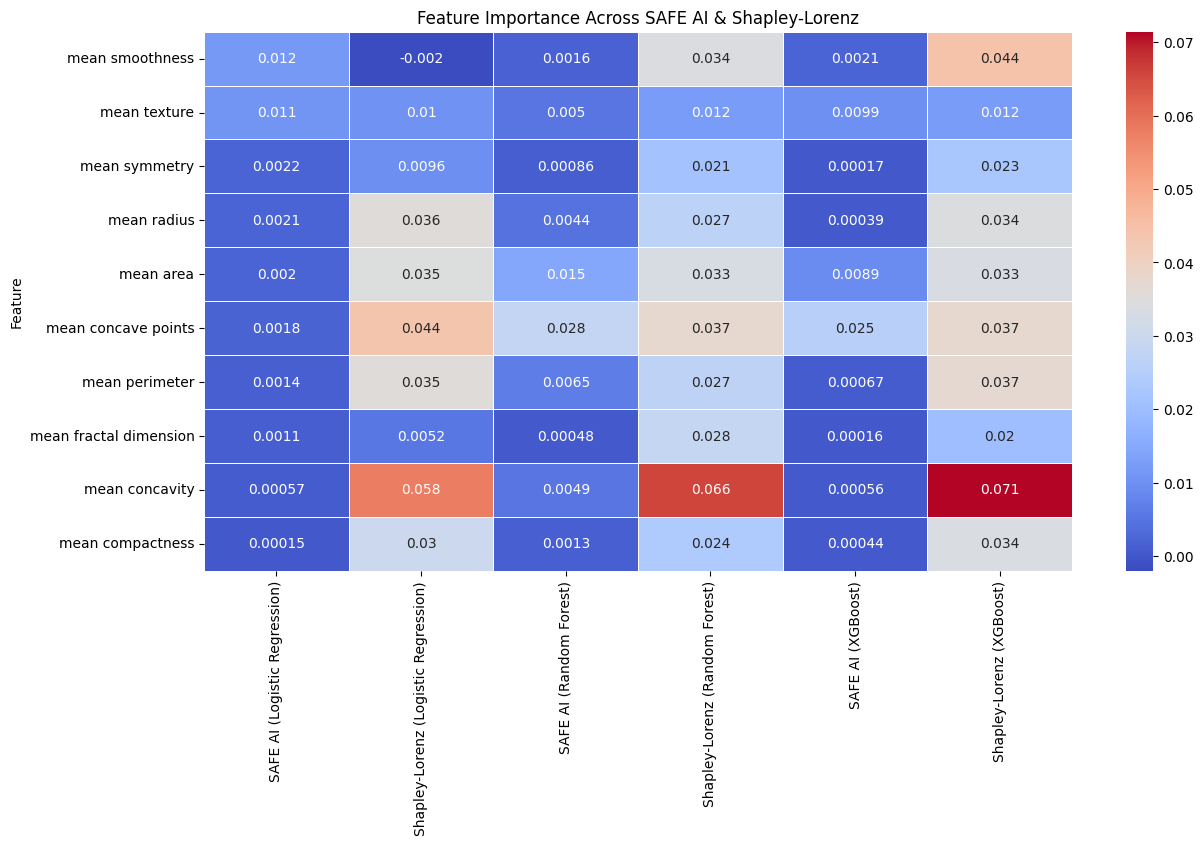

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_importance(importance_df):
    """
    Plots feature importance from SAFE AI and Shapley-Lorenz for all models.
    """
    plt.figure(figsize=(14, 7))
    sns.heatmap(importance_df.set_index("Feature"), annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title("Feature Importance Across SAFE AI & Shapley-Lorenz")
    plt.show()

# Plot the comparison
plot_feature_importance(feature_comparison_df)